## 多头注意力
在实践中，当给定相同的查询、键和值的集合时，我们希望模型可以基于相同的注意⼒机制学习到不同的⾏
为，然后将不同的⾏为作为知识组合起来，捕获序列内各种范围的依赖关系（例如，短距离依赖和⻓距离依
赖关系）。因此，允许注意⼒机制组合使⽤查询、键和值的不同 ⼦空间表⽰（representation subspaces）可
能是有益的。

为此，与其只使⽤单独⼀个注意⼒汇聚，我们可以⽤独⽴学习得到的h组不同的 线性投影（linear projections）
来变换查询、键和值。然后，这h组变换后的查询、键和值将并⾏地送到注意⼒汇聚中。最后，将这h个注意
⼒汇聚的输出拼接在⼀起，并且通过另⼀个可以学习的线性投影进⾏变换，以产⽣最终输出。这种设计被称
为多头注意⼒（multihead attention）(Vaswani et al., 2017)。对于h个注意⼒汇聚输出，每⼀个注意⼒汇聚都
被称作⼀个头（head）。图10.5.1 展⽰了使⽤全连接层来实现可学习的线性变换的多头注意⼒。

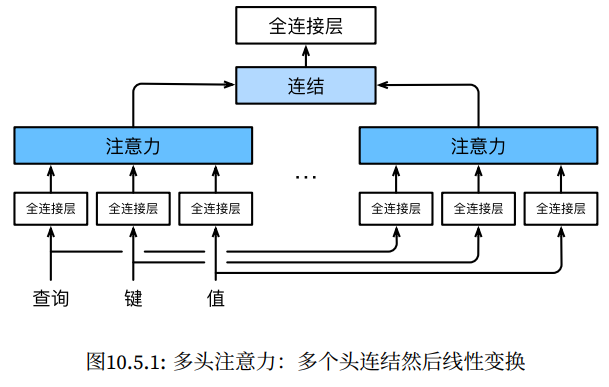

### 模型
在实现多头注意⼒之前，让我们⽤数学语⾔将这个模型形式化地描述出来。给定查询q ∈ R
dq、键k ∈ Rdk和值v ∈ Rdv，每个注意⼒头hi（i = 1, . . . , h）的计算⽅法为：

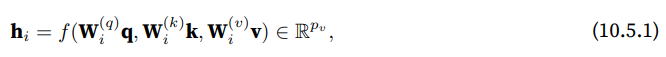  

其中，可学习的参数包括 W(q)i ∈ Rpq×dq、W
(k)i ∈ Rpk×dk和 W(v)i ∈ Rpv×dv，以及代表注意⼒汇聚的函数f。f可
以是 10.3节中的加性注意⼒和缩放点积注意⼒。多头注意⼒的输出需要经过另⼀个线性转换，它对应着h个
头连结后的结果，因此其可学习参数是 Wo ∈ Rpo×hpv：

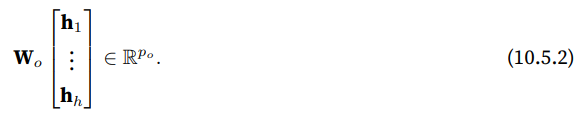

基于这种设计，每个头都可能会关注输⼊的不同部分，可以表⽰⽐简单加权平均值更复杂的函数。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l


### 实现
在实现过程中通常选择缩放点积注意⼒作为每⼀个注意⼒头。为了避免计算代价和参数代价的⼤幅增⻓，我
们设定pq = pk = pv = po/h。值得注意的是，如果将查询、键和值的线性变换的输出数量设置为 pqh = pkh =
pvh = po，则可以并⾏计算h个头。在下⾯的实现中，po是通过参数num_hiddens指定的。


In [3]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意⼒"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
        num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens 的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values 的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            # 在轴0，将第⼀项（标量或者⽮量）复制num_heads次，
            # 然后如此复制第⼆项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


为了能够使多个头并⾏计算，上⾯的MultiHeadAttention类将使⽤下⾯定义的两个转置函数。具体来说，trans-pose_output函数反转了transpose_qkv函数的操作


In [4]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意⼒头的并⾏计算⽽变换形状"""
    # 输⼊X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

下⾯使⽤键和值相同的⼩例⼦来测试我们编写的MultiHeadAttention类。多头注意⼒输出的形状是（batch_size，num_queries，num_hiddens）。


In [5]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [6]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## 小结
* 多头注意⼒融合了来⾃于多个注意⼒汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的⼦空间表⽰。
* 基于适当的张量操作，可以实现多头注意⼒的并⾏计算。